# Read in

In [1]:
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd

from src.helpers import make_aesthetic

mypal = make_aesthetic()

bad_words = []

arxiv_word_counts = pd.read_json('../data/clean/arxiv_word_counts.json',lines=True)
arxiv_word_counts['wc'] = arxiv_word_counts['text'].swifter.apply(lambda x: len(x.split()))
arxiv_word_counts['social_word_counts'] = arxiv_word_counts['social_word_counts'].swifter.apply(lambda x: {k: v for k, v in x.items() if k not in bad_words})

nyt_word_counts = pd.read_json('../data/clean/nyt_word_counts.json',lines=True)
nyt_word_counts['wc'] = nyt_word_counts['text'].swifter.apply(lambda x: len(x.split()))
nyt_word_counts['social_word_counts'] = nyt_word_counts['social_word_counts'].swifter.apply(lambda x: {k: v for k, v in x.items() if k not in bad_words})

product_word_counts = pd.read_json('../data/clean/prod_hunt_word_counts.json',lines=True)
product_word_counts['wc'] = product_word_counts['text'].swifter.apply(lambda x: len(x.split()))
product_word_counts['social_word_counts'] = product_word_counts['social_word_counts'].swifter.apply(lambda x: {k: v for k, v in x.items() if k not in bad_words})

dfs = {
    'arxiv': arxiv_word_counts,
    'nyt': nyt_word_counts,
    'producthunt': product_word_counts
}


Pandas Apply:   0%|          | 0/613178 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/613178 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/383122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/383122 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/263635 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/263635 [00:00<?, ?it/s]

# Process dfs

In [2]:
from collections import Counter
class TFIDFCalculator:
    


    """
    A class to calculate TF-IDF scores for a DataFrame column containing word count dictionaries.
    """
    

    
    def __init__(self, df, word_count_column, N=None):
        """
        Initialize the TF-IDF calculator.
        
        Args:
            df (pd.DataFrame): The input DataFrame
            word_count_column (str): Name of the column containing word count dictionaries
            N (int, optional): Total number of documents to use in IDF calculation. 
                             If None, uses count of non-null documents in the DataFrame.
        """
        self.df = df.copy()
        self.word_count_column = word_count_column
        self.custom_N = N
        self.idf_scores = {}
        self.N = 0
        
    def calculate_tfidf(self):
        """
        Calculate TF-IDF scores and add them to the DataFrame.
        
        Returns:
            pd.DataFrame: DataFrame with added TF-IDF columns
        """
        # Step 1: Calculate Document Frequency (DF)
        self._calculate_document_frequencies()
        
        # Step 2: Calculate IDF scores
        self._calculate_idf_scores()
        
        # Step 3: Calculate TF-IDF for each row
        self._calculate_row_tfidf()
        
        return self.df
    
    def _calculate_document_frequencies(self):
        """Calculate how many documents each word appears in."""
        doc_counts_per_word = Counter()
        valid_word_counts = self.df[self.word_count_column].dropna()
        
        for wc_dict in valid_word_counts:
            if isinstance(wc_dict, dict) and wc_dict:
                doc_counts_per_word.update(wc_dict.keys())
        
        self.doc_counts_per_word = doc_counts_per_word
        # Use custom N if provided, otherwise count non-null documents
        self.N = self.custom_N if self.custom_N is not None else len(self.df[self.df[self.word_count_column].notna()])
    
    def _calculate_idf_scores(self):
        """Calculate smoothed exponential IDF scores that emphasize unique terms."""
        alpha = 1 # Adjust: 1.0 = no boost, 2.0 = strong boost
        for word in self.doc_counts_per_word.keys():
            df_term = self.doc_counts_per_word[word]
            # Smoothed exponential IDF
            raw_idf = ((self.N + 1) / (df_term + 1)) ** alpha + 1
            self.idf_scores[word] = min(raw_idf, 1000)  # Cap extreme values
    
    def _calculate_row_tfidf(self):
        """Calculate TF-IDF scores for each row and add to DataFrame."""
        tfidf_column = f"{self.word_count_column}_tfidf"
        sum_tfidf_column = f"sum_{self.word_count_column}_tfidf"
        
        self.df[tfidf_column] = self.df[self.word_count_column].swifter.apply(self._calculate_single_row_tfidf)
        self.df[sum_tfidf_column] = self.df[tfidf_column].swifter.apply(
            lambda x: sum(x.values()) if isinstance(x, dict) else 0
        )
    
    def _calculate_single_row_tfidf(self, row_word_counts):
        """
        Calculate TF-IDF scores for a single row's word counts.
        
        Args:
            row_word_counts (dict): Dictionary of word counts for a single document
            
        Returns:
            dict: Dictionary of TF-IDF scores for each word
        """
        if not isinstance(row_word_counts, dict) or not row_word_counts:
            return {}
        
        total_words_in_doc = sum(row_word_counts.values())
        if total_words_in_doc == 0:
            return {}
        
        row_tfidf = {}
        for word, count in row_word_counts.items():
            tf = count / total_words_in_doc
            idf = self.idf_scores.get(word, 0)
            row_tfidf[word] = tf * idf
        
        return row_tfidf
    

dfs = {
   'arxiv': arxiv_word_counts,
   'nyt': nyt_word_counts,
   'producthunt': product_word_counts
}

byday = {}

for name, df in dfs.items():

   
   # get only ai
   df = df.query("ai_binary ==1")
   
   # dt
   df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
   df['total_count'] = 1
   
   calculator = TFIDFCalculator(df, "social_word_counts", N=df.query("social_word_counts.notna()").shape[0])
   df = calculator.calculate_tfidf()
   
   df['ai_compound_sum'] = df['ai_compound_roles_sum'] + df['ai_compound_nouns_sum']
   df['ai_compound_binary'] = df['ai_compound_sum'].swifter.apply(lambda x: 1 if x > 0 else 0)
   
   
   
   # Convert count columns to int
   sum_cols = [col for col in df.columns if "sum" in col]
   for col in sum_cols:
       df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
       df[f"{col}_mean"] = df[col]
       df[f"{col}_mean_prop_wc"] = df[col] / df['wc']
       
   # Convert binary columns to int
   binary_cols = [col for col in df.columns if "binary" in col]
   for col in binary_cols:
       df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
       df[f"{col}_sum"] = df[col]
       
   print(f"Dataset: {name}")
   print(f"Number of rows: {len(df)}")
   print(f"Number of columns: {len(df.columns)}")
   print(f"Columns: {df.columns.tolist()}")
   
   dfs[name] = df
   
   # Group by date and aggregate
   df_grouped = df.groupby(by=['dt']).agg({
       **{col: 'sum' for col in sum_cols},  # Sum for count columns
       **{col: 'mean' for col in binary_cols},  # Mean for binary columns, 
       **{f"{col}_mean": 'mean' for col in sum_cols},  # Mean for count columns
       **{f"{col}_sum": 'sum' for col in binary_cols},  # Sum for binary columns
       'total_count': 'sum'  # Sum for the total_count column
   }).reset_index()
   
   
   byday[name] = df_grouped

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/82450554.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/82450554.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_count'] = 1


Pandas Apply:   0%|          | 0/99487 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99487 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99487 [00:00<?, ?it/s]

Dataset: arxiv
Number of rows: 99487
Number of columns: 52
Columns: ['base-ai_word_counts', 'ai_word_counts', 'social_word_counts', 'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts', 'ai_compound_word_counts', 'advice_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum', 'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum', 'advice_sum', 'base-ai_binary', 'ai_binary', 'social_binary', 'ai_compound_roles_binary', 'ai_compound_nouns_binary', 'ai_compound_binary', 'advice_binary', 'analysis_date', 'unique_idx', 'text', 'wc', 'dt', 'total_count', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf', 'base-ai_sum_mean', 'base-ai_sum_mean_prop_wc', 'ai_sum_mean', 'ai_sum_mean_prop_wc', 'social_sum_mean', 'social_sum_mean_prop_wc', 'ai_compound_roles_sum_mean', 'ai_compound_roles_sum_mean_prop_wc', 'ai_compound_nouns_sum_mean', 'ai_compound_nouns_sum_mean_prop_wc', 'ai_compound_sum_mean', 'ai_compound_sum_mean_prop_wc', 'advice_sum_mean', 'advice_sum_mean_pr

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/82450554.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/82450554.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_count'] = 1


Pandas Apply:   0%|          | 0/2008 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2008 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2008 [00:00<?, ?it/s]

Dataset: nyt
Number of rows: 2008
Number of columns: 52
Columns: ['base-ai_word_counts', 'ai_word_counts', 'social_word_counts', 'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts', 'ai_compound_word_counts', 'advice_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum', 'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum', 'advice_sum', 'base-ai_binary', 'ai_binary', 'social_binary', 'ai_compound_roles_binary', 'ai_compound_nouns_binary', 'ai_compound_binary', 'advice_binary', 'analysis_date', 'unique_idx', 'text', 'wc', 'dt', 'total_count', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf', 'base-ai_sum_mean', 'base-ai_sum_mean_prop_wc', 'ai_sum_mean', 'ai_sum_mean_prop_wc', 'social_sum_mean', 'social_sum_mean_prop_wc', 'ai_compound_roles_sum_mean', 'ai_compound_roles_sum_mean_prop_wc', 'ai_compound_nouns_sum_mean', 'ai_compound_nouns_sum_mean_prop_wc', 'ai_compound_sum_mean', 'ai_compound_sum_mean_prop_wc', 'advice_sum_mean', 'advice_sum_mean_prop_

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/82450554.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/82450554.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_count'] = 1


Pandas Apply:   0%|          | 0/43427 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/43427 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/43427 [00:00<?, ?it/s]

Dataset: producthunt
Number of rows: 43427
Number of columns: 52
Columns: ['base-ai_word_counts', 'ai_word_counts', 'social_word_counts', 'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts', 'ai_compound_word_counts', 'advice_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum', 'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum', 'advice_sum', 'base-ai_binary', 'ai_binary', 'social_binary', 'ai_compound_roles_binary', 'ai_compound_nouns_binary', 'ai_compound_binary', 'advice_binary', 'analysis_date', 'unique_idx', 'text', 'wc', 'dt', 'total_count', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf', 'base-ai_sum_mean', 'base-ai_sum_mean_prop_wc', 'ai_sum_mean', 'ai_sum_mean_prop_wc', 'social_sum_mean', 'social_sum_mean_prop_wc', 'ai_compound_roles_sum_mean', 'ai_compound_roles_sum_mean_prop_wc', 'ai_compound_nouns_sum_mean', 'ai_compound_nouns_sum_mean_prop_wc', 'ai_compound_sum_mean', 'ai_compound_sum_mean_prop_wc', 'advice_sum_mean', 'advice_sum_m

# Plot ts (individual)

Plotting arxiv - social_sum (monthly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


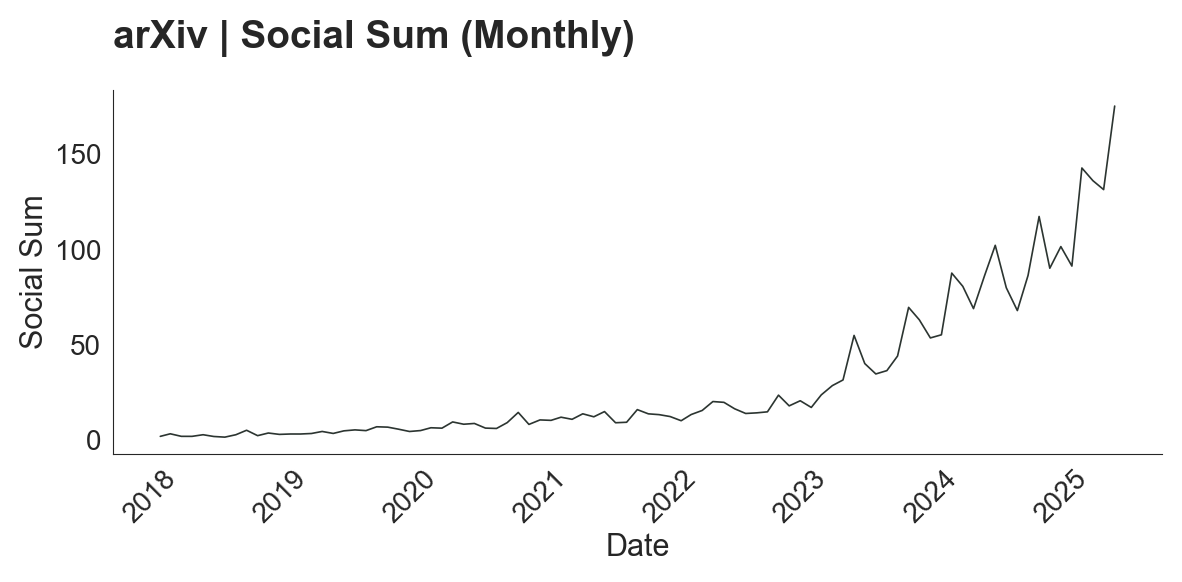

Plotting arxiv - social_sum (yearly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


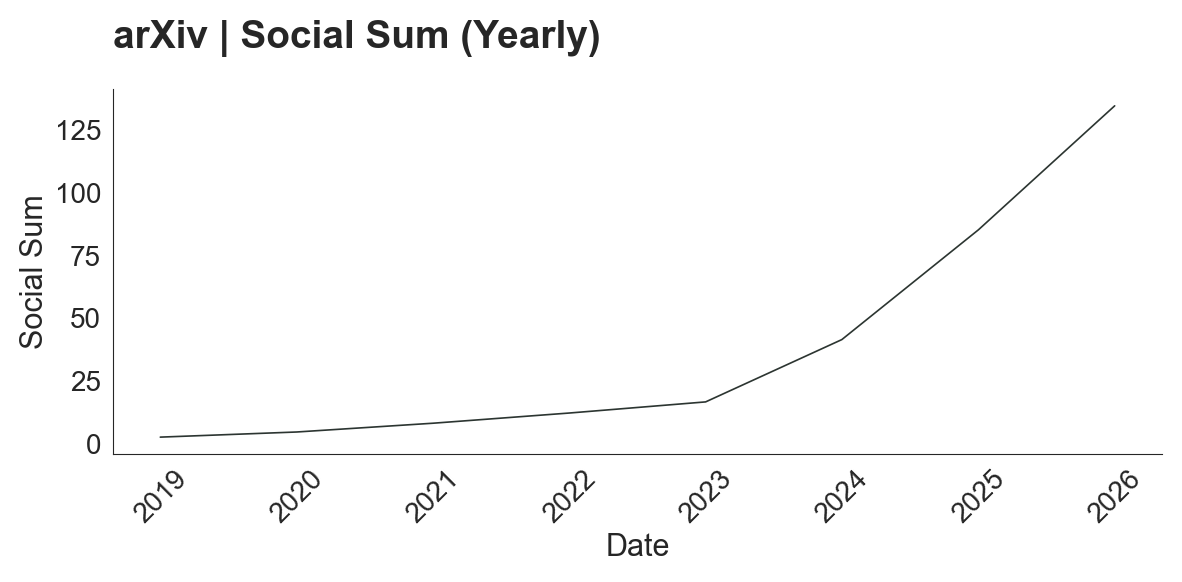

Plotting arxiv - ai_compound_sum (monthly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


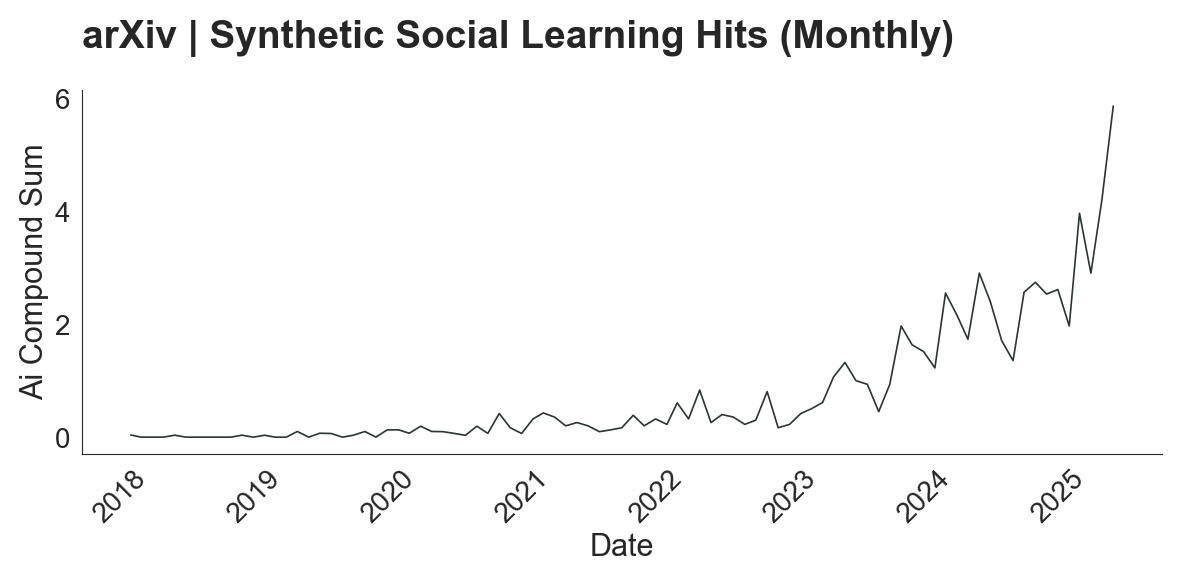

Plotting arxiv - ai_compound_sum (yearly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


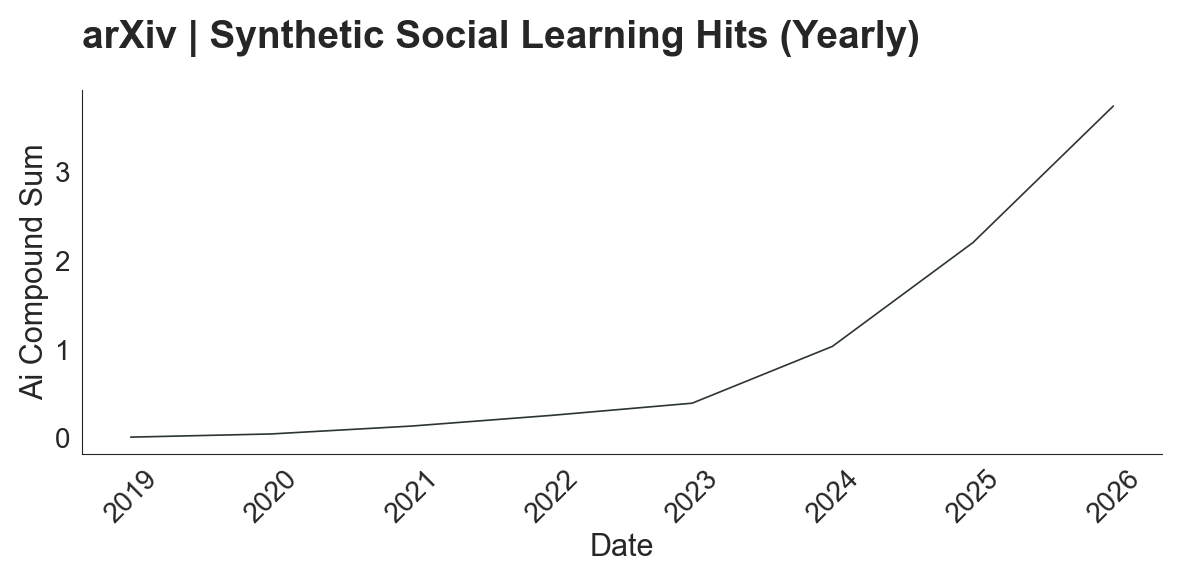

Plotting arxiv - social_binary (monthly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


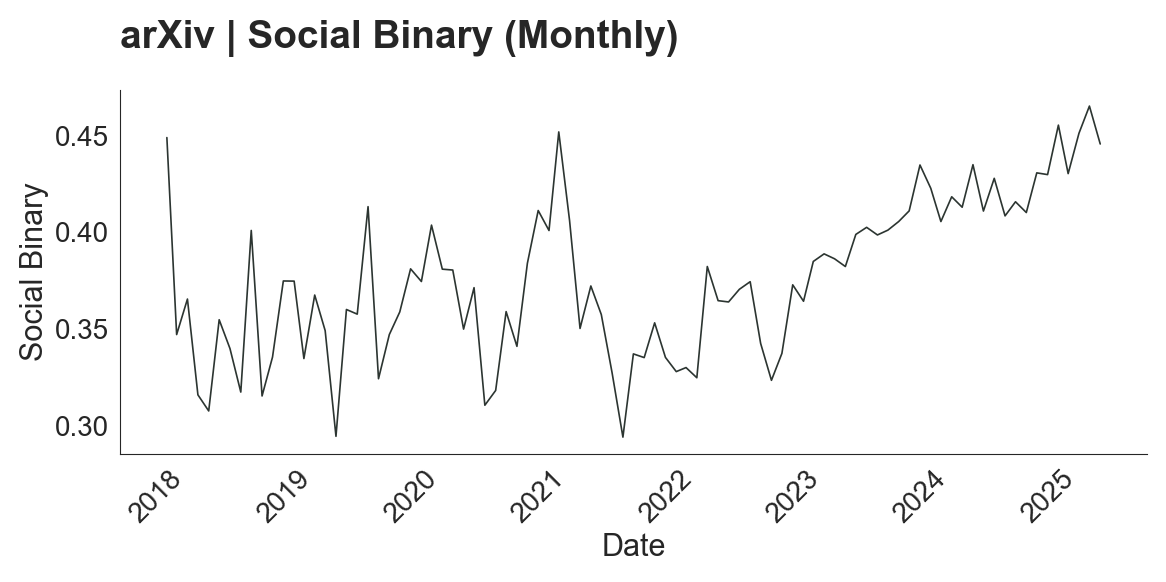

Plotting arxiv - social_binary (yearly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


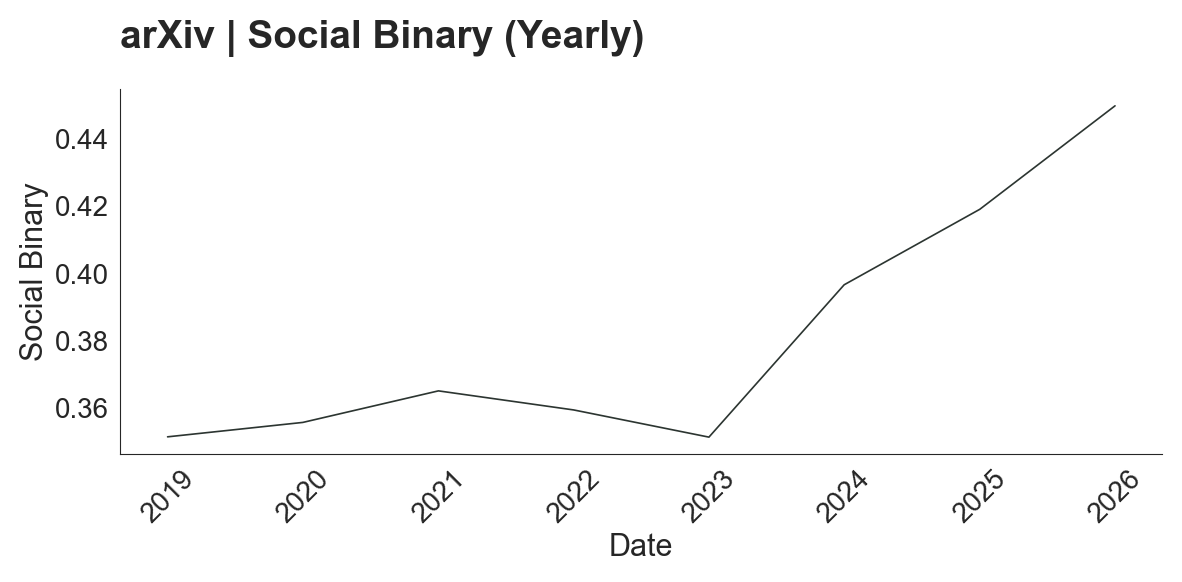

Plotting producthunt - social_sum (monthly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


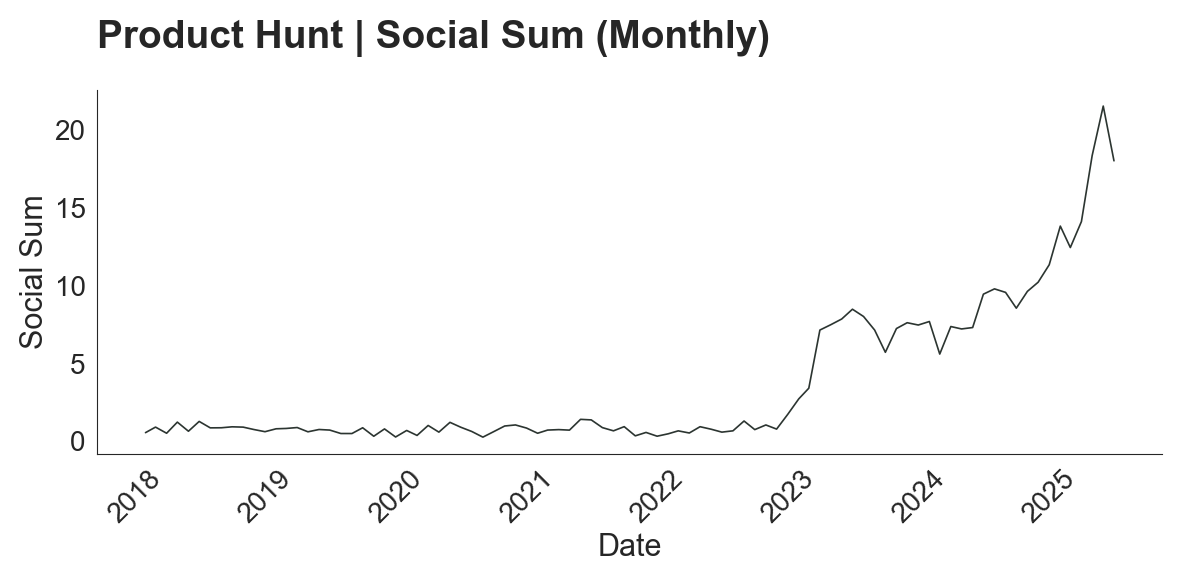

Plotting producthunt - social_sum (yearly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


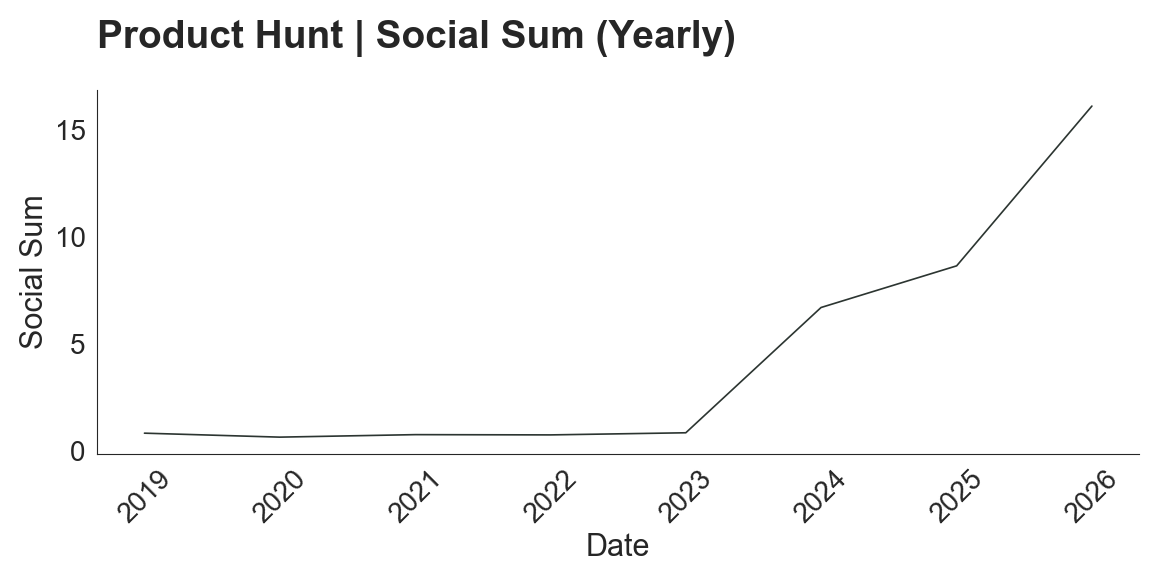

Plotting producthunt - ai_compound_sum (monthly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


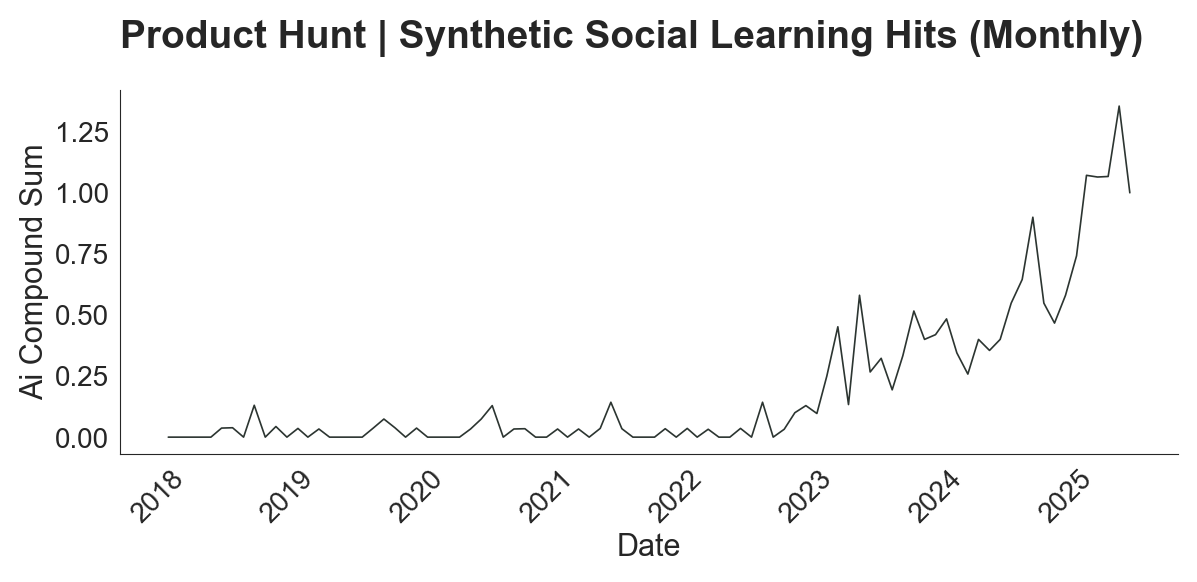

Plotting producthunt - ai_compound_sum (yearly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


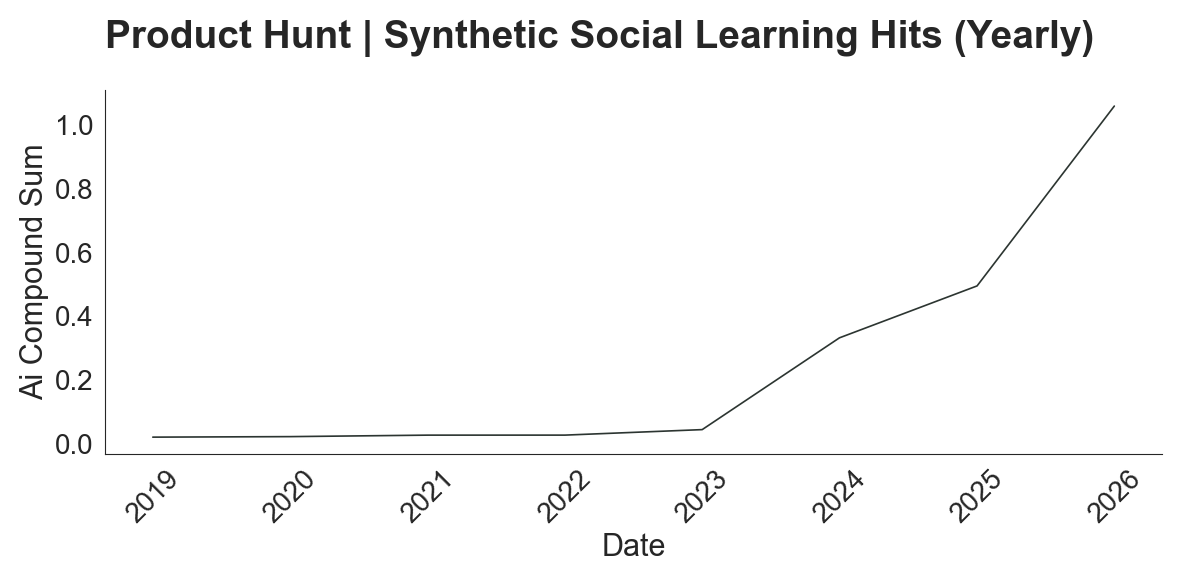

Plotting producthunt - social_binary (monthly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


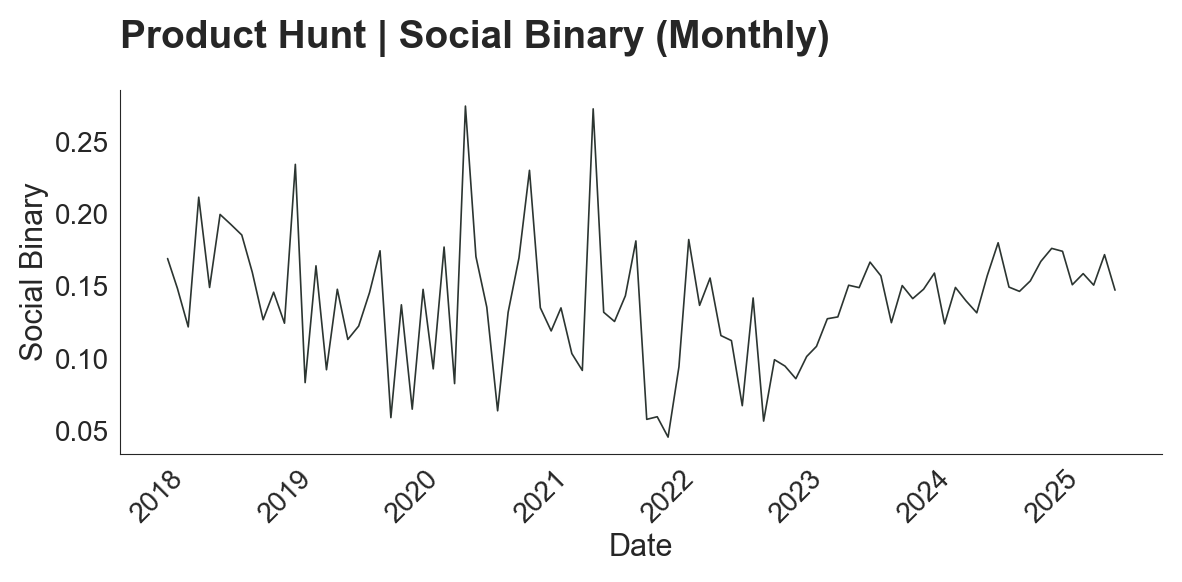

Plotting producthunt - social_binary (yearly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


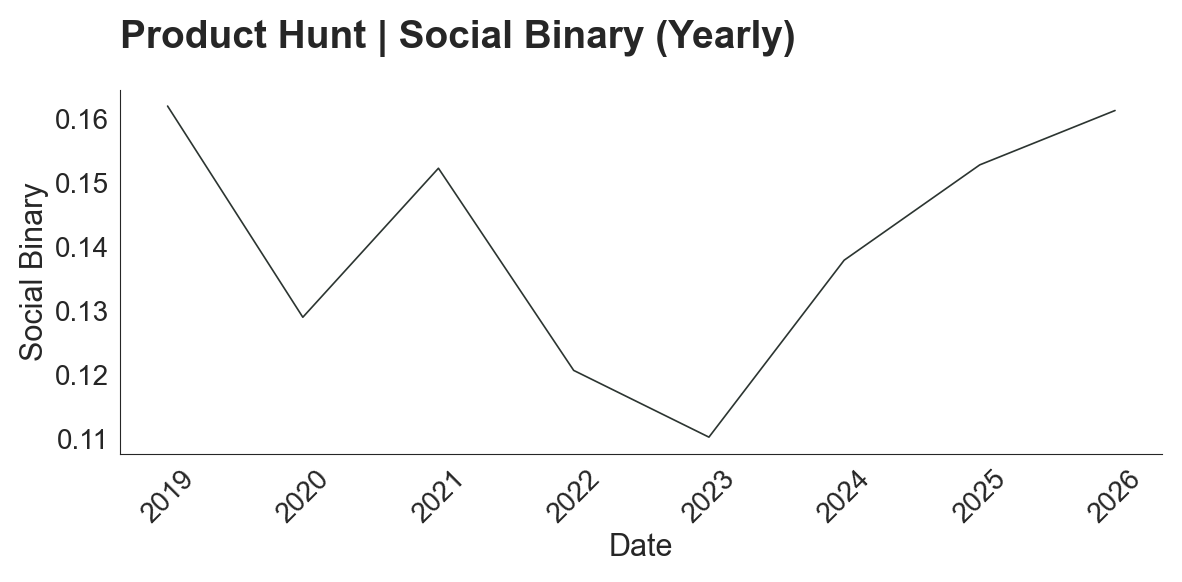

Plotting nyt - social_sum (monthly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


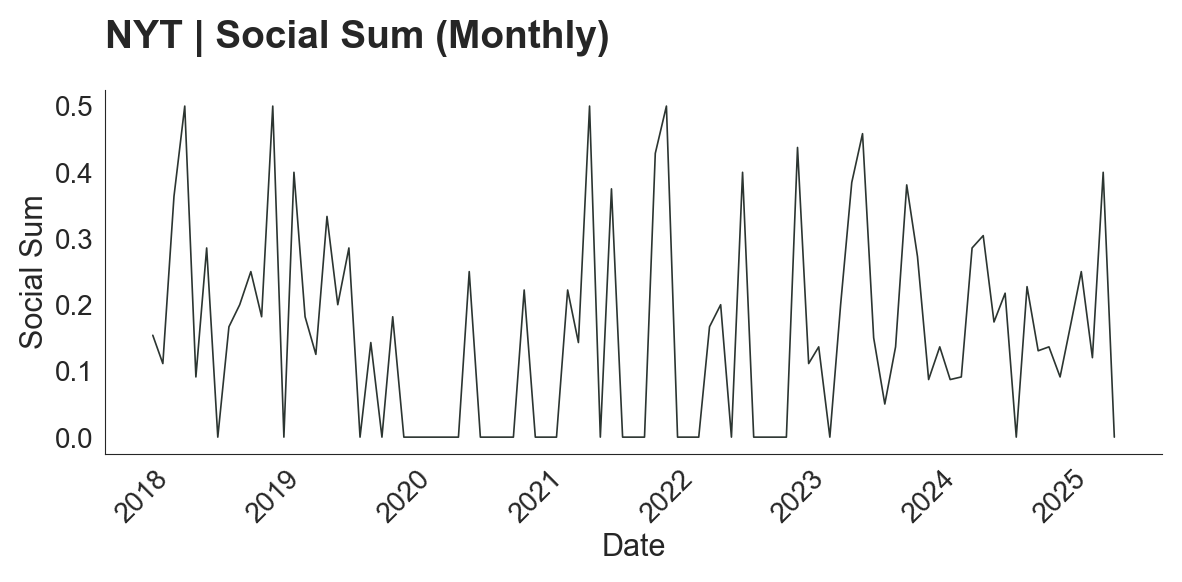

Plotting nyt - social_sum (yearly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


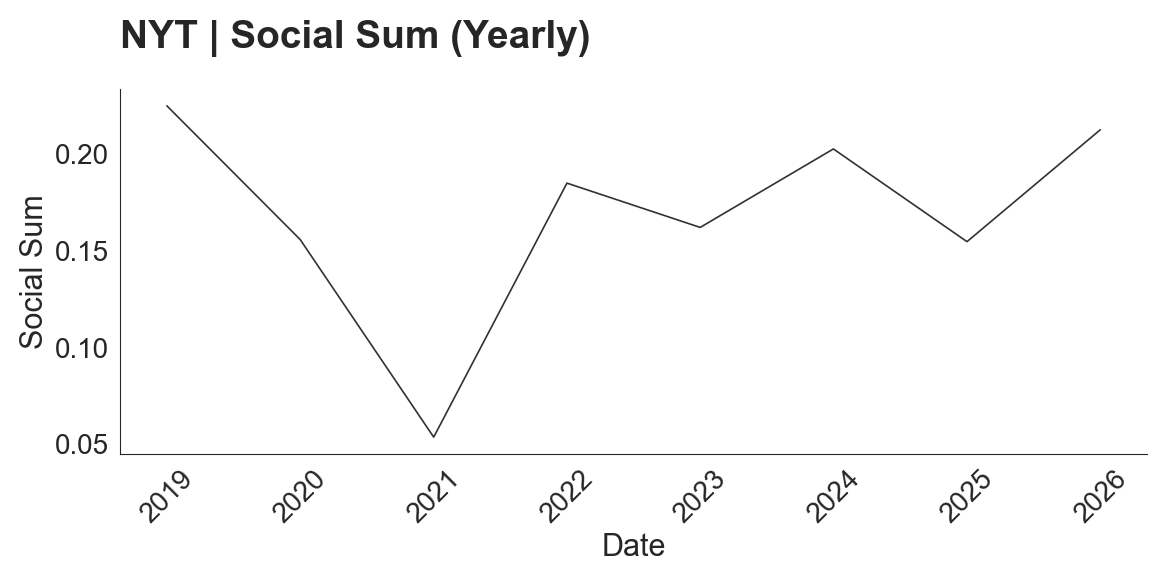

Plotting nyt - ai_compound_sum (monthly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


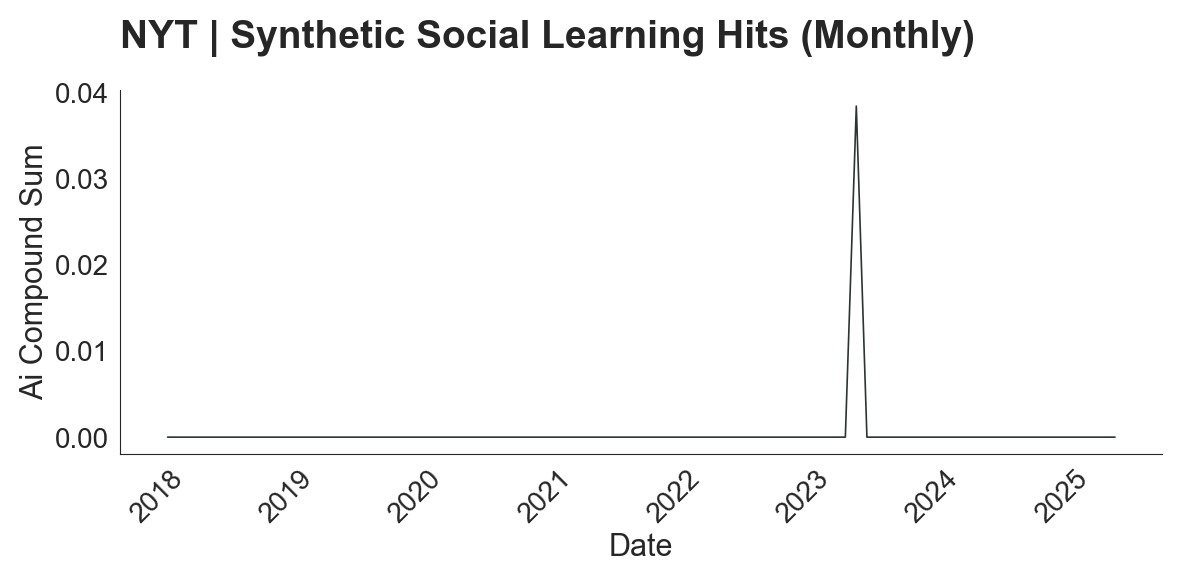

Plotting nyt - ai_compound_sum (yearly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


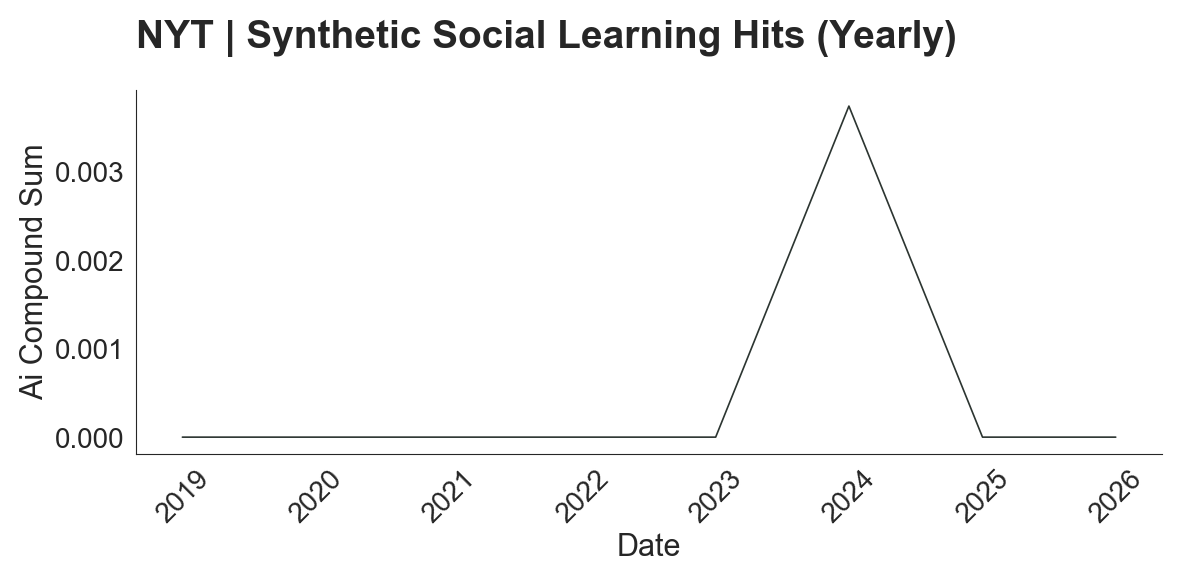

Plotting nyt - social_binary (monthly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


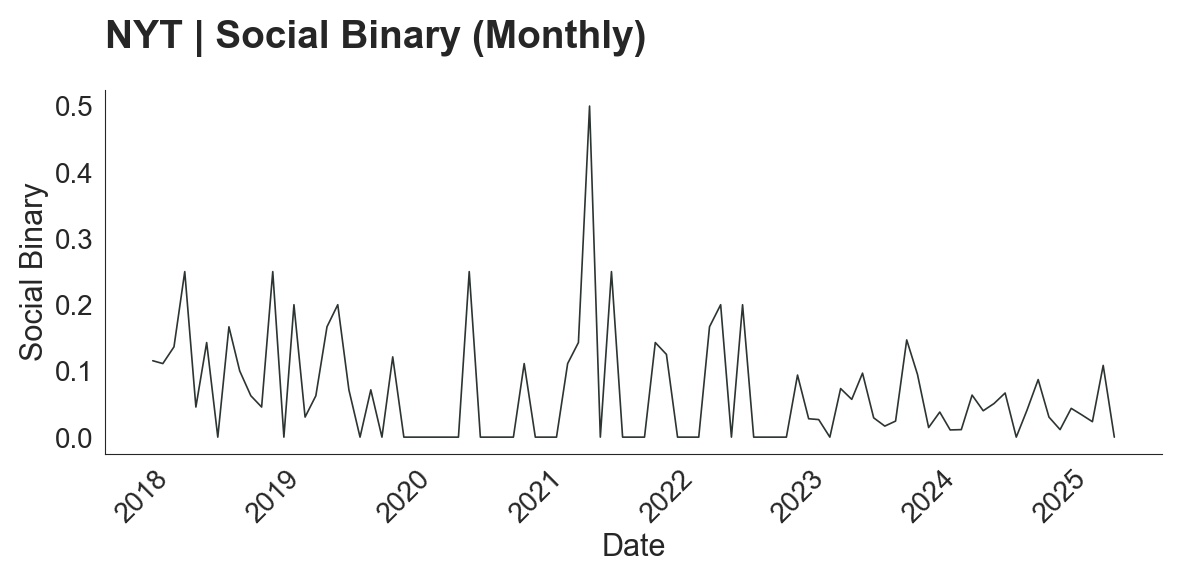

Plotting nyt - social_binary (yearly)


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/507504839.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


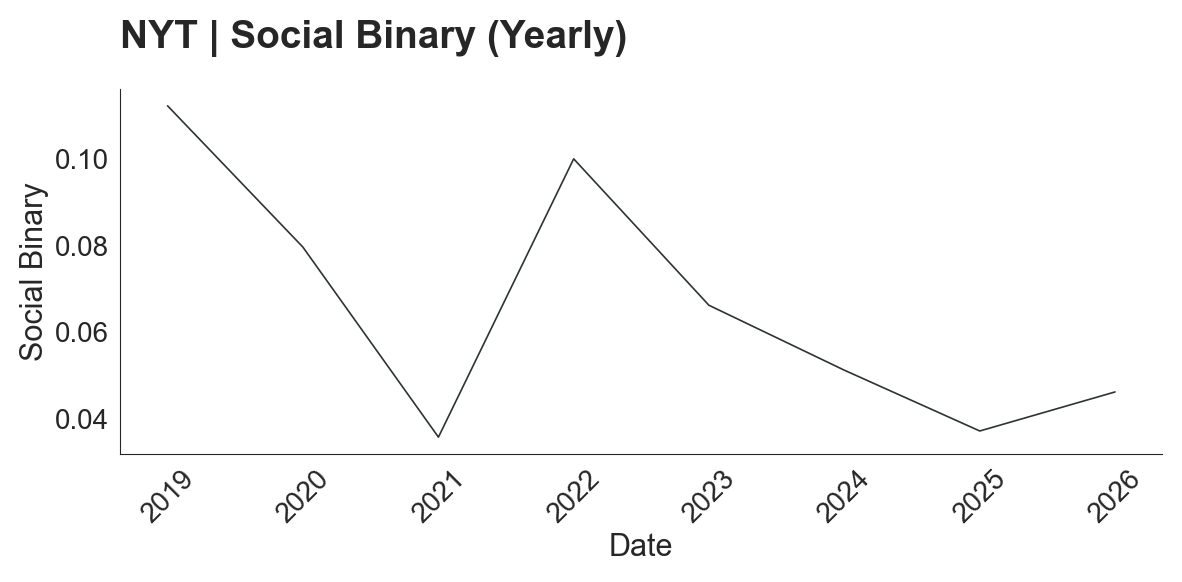

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd

def plot_ts(name, col, smoothing=False, period='daily', figsize=(12, 6)):
   """
   Plot time series for a given dataset and column.
   
   Parameters:
   -----------
   name : str
       Dataset name (key in byday dictionary)
   col : str
       Column name to plot
   smoothing : bool or int
       If True, applies 7-day rolling average. If int, uses that window size.
   period : str
       Aggregation period: 'daily', 'weekly', 'monthly', 'yearly'
   figsize : tuple
       Figure size (width, height)
   """
   
   clean_col = col.replace('_', ' ').title()
   if col == 'ai_compound_sum':
       clean_col = "Synthetic Social Learning Hits"
       
   
   source_dict = {
         'arxiv': 'arXiv',
         'nyt': 'NYT',
         'producthunt': 'Product Hunt'
   }
   clean_source = source_dict.get(name)
   if clean_col.startswith("Ai"):
         clean_col = clean_col.replace("Ai", "AI")
   
   if name not in byday:
       raise ValueError(f"Dataset '{name}' not found. Available: {list(byday.keys())}")
   
   df = byday[name].copy()
   
   if col not in df.columns:
       raise ValueError(f"Column '{col}' not found. Available: {df.columns.tolist()}")
   
   # Resample based on period
   if period == 'daily':
       df_plot = df.set_index('dt').resample('D')[col].sum().reset_index()
   elif period == 'weekly':
       df_plot = df.set_index('dt').resample('W')[col].mean().reset_index()
   elif period == 'monthly':
       df_plot = df.set_index('dt').resample('M')[col].mean().reset_index()
   elif period == 'yearly':
       df_plot = df.set_index('dt').resample('Y')[col].mean().reset_index()
   else:
       raise ValueError("Period must be 'daily', 'weekly', 'monthly', or 'yearly'")
   
   # Apply smoothing if requested
   if smoothing:
       window = 7 if smoothing is True else int(smoothing)
       df_plot[f'{col}_smooth'] = df_plot[col].rolling(window=window, center=True).mean()
       plot_col = f'{col}_smooth'
       line_label = f'{col} ({window}-period moving average)'
   else:
       plot_col = col
       line_label = col
   
   # Create plot
   plt.figure(figsize=figsize)
   plt.plot(df_plot['dt'], df_plot[plot_col])
   
   # Formatting
   plt.title(f'{clean_source} | {clean_col} ({period.title()})',  fontweight='bold')
   plt.xlabel('Date')
   plt.ylabel(col.replace('_', ' ').title())
   
   plt.xticks(rotation=45)
   plt.tight_layout()
   

   
   return df_plot

# Example usage:
for source in ['arxiv', 'producthunt', 'nyt']:
    for dv in ['social_sum', 'ai_compound_sum', 'social_binary']:
            for period in ['monthly', 'yearly']:
                print(f"Plotting {source} - {dv} ({period})")
                plot_ts(source, dv, smoothing=False, period=period)
                plt.show()




it has # grid plot

In [ ]:
sorted(byday['arxiv'].columns)

# Grid plot of all time series

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_14459/1891264110.py:65: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=2.0)


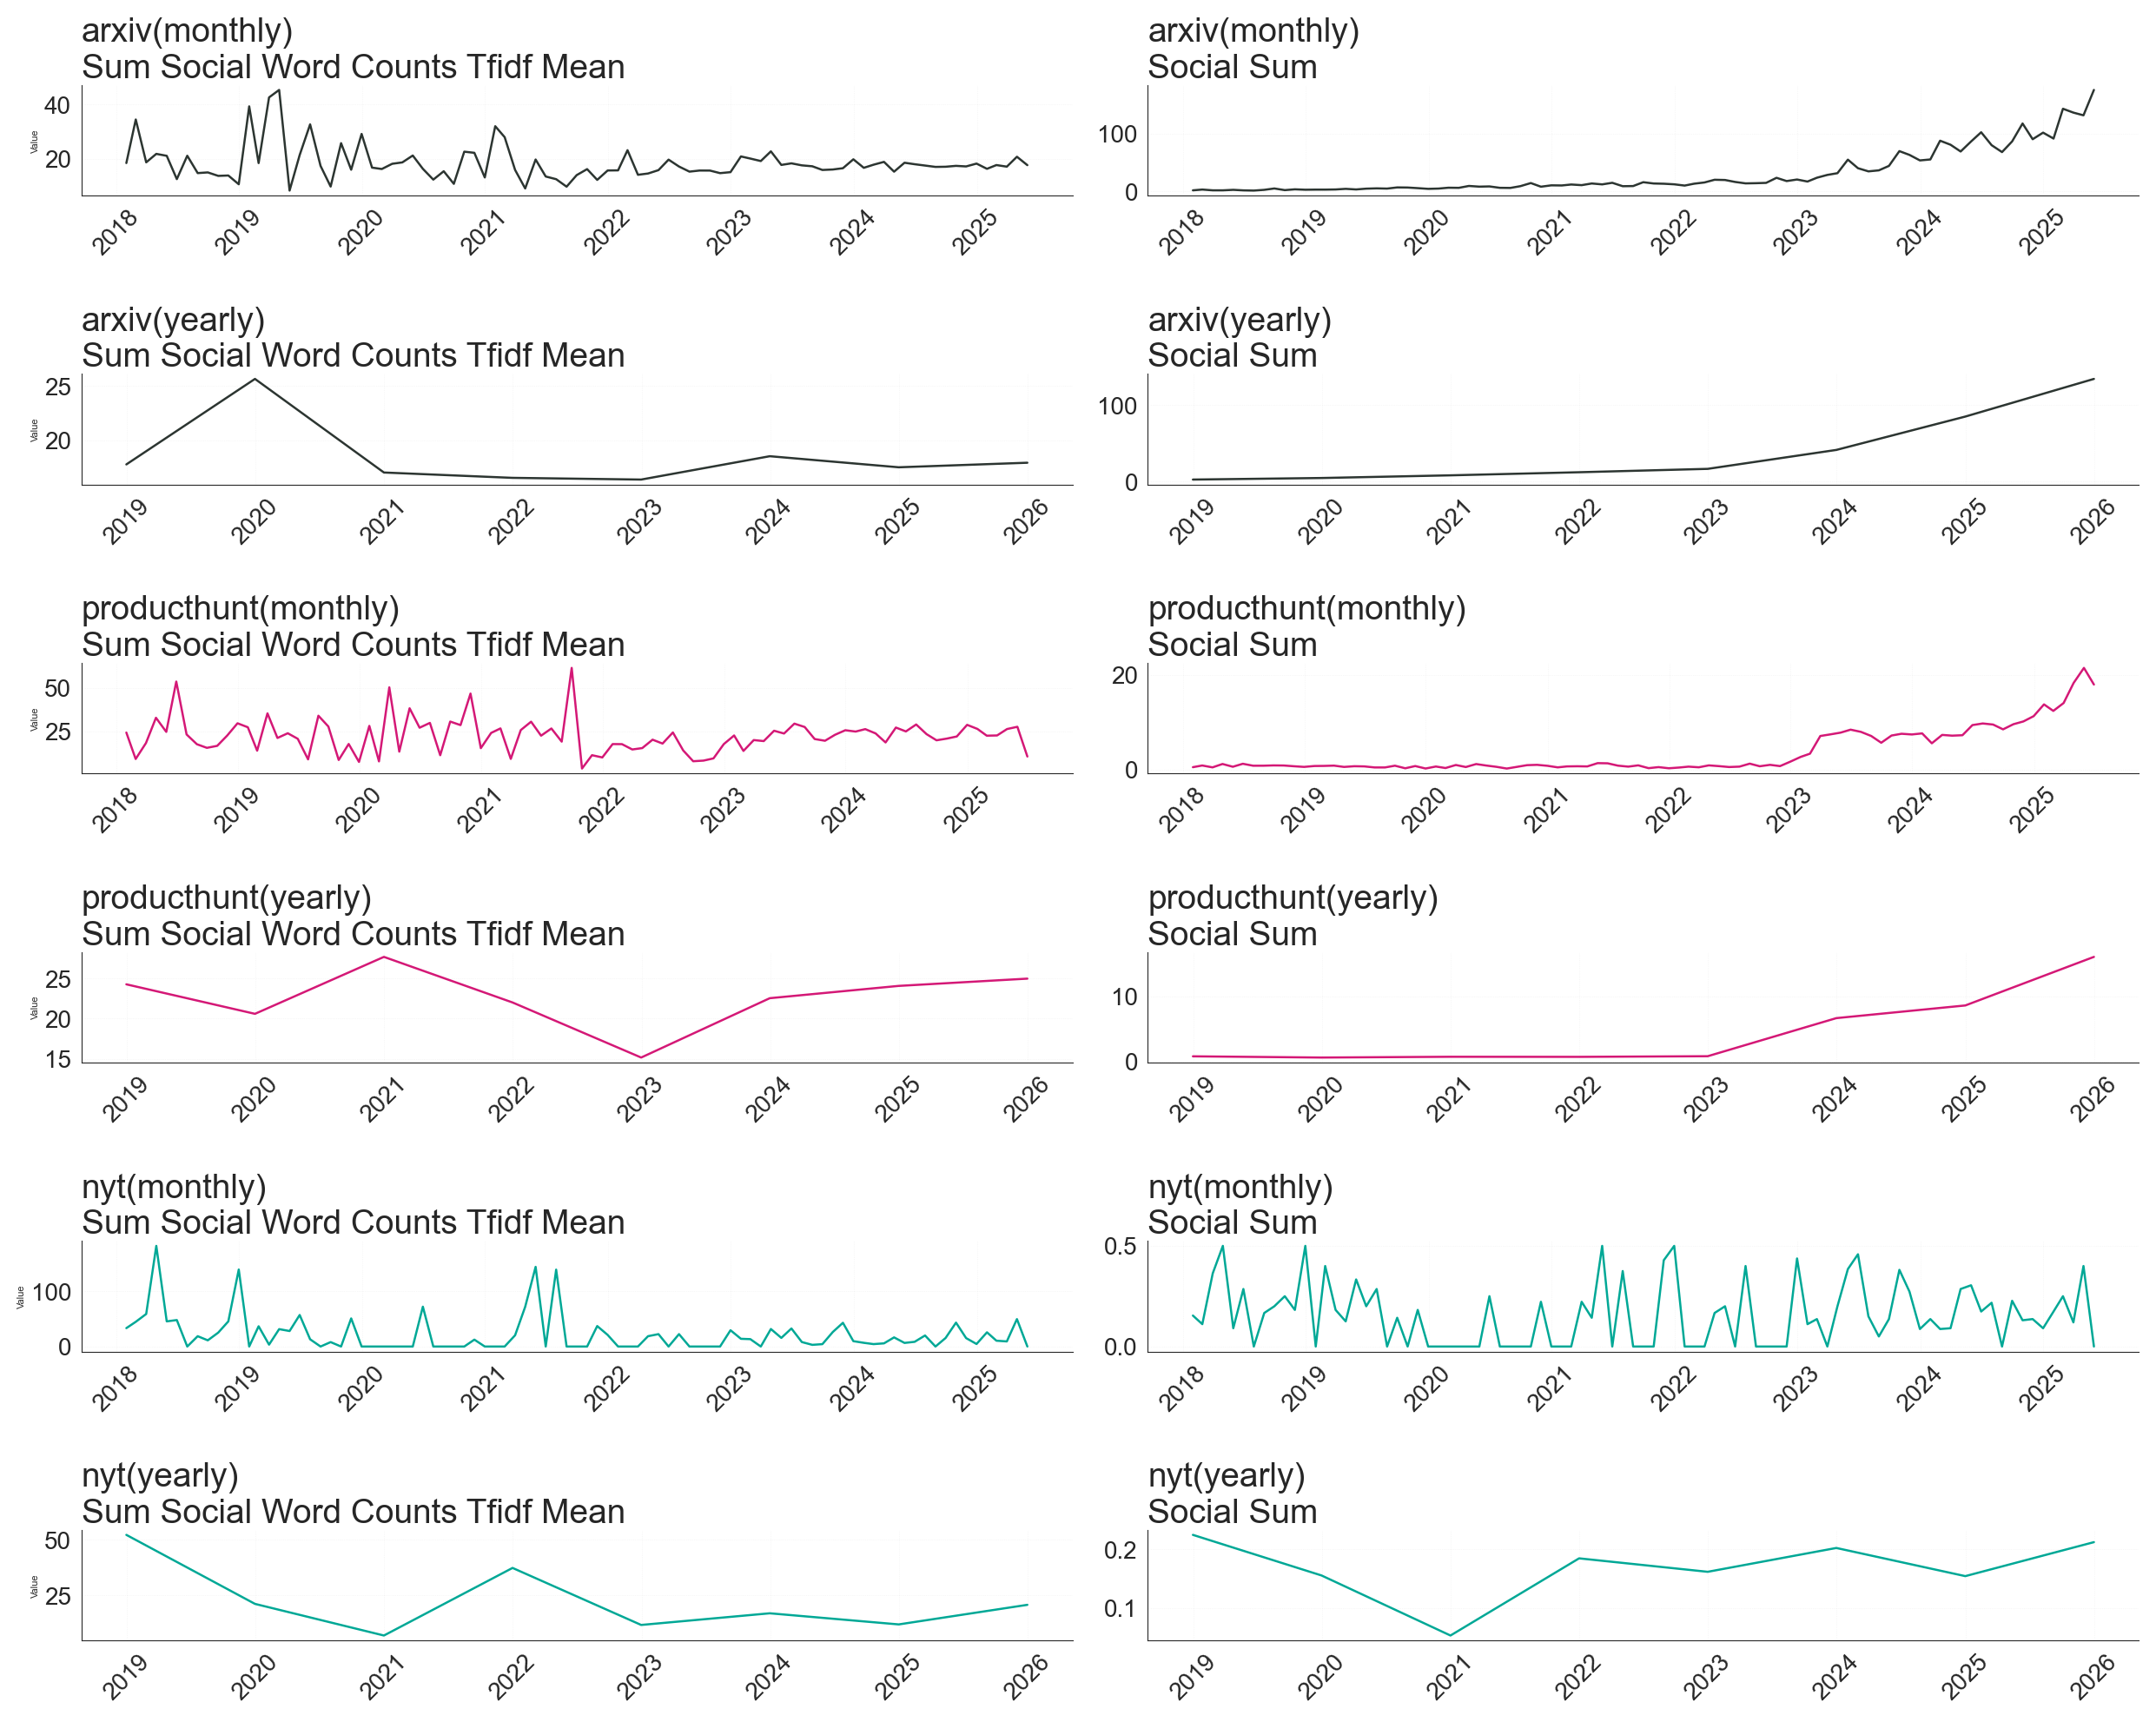

✅  Saved grid to all_time_series.png


In [10]:
sorted(dfs['arxiv'].columns)

['advice_binary',
 'advice_binary_sum',
 'advice_sum',
 'advice_sum_mean',
 'advice_sum_mean_prop_wc',
 'advice_word_counts',
 'ai_binary',
 'ai_binary_sum',
 'ai_compound_binary',
 'ai_compound_binary_sum',
 'ai_compound_nouns_binary',
 'ai_compound_nouns_binary_sum',
 'ai_compound_nouns_sum',
 'ai_compound_nouns_sum_mean',
 'ai_compound_nouns_sum_mean_prop_wc',
 'ai_compound_nouns_word_counts',
 'ai_compound_roles_binary',
 'ai_compound_roles_binary_sum',
 'ai_compound_roles_sum',
 'ai_compound_roles_sum_mean',
 'ai_compound_roles_sum_mean_prop_wc',
 'ai_compound_roles_word_counts',
 'ai_compound_sum',
 'ai_compound_sum_mean',
 'ai_compound_sum_mean_prop_wc',
 'ai_compound_word_counts',
 'ai_sum',
 'ai_sum_mean',
 'ai_sum_mean_prop_wc',
 'ai_word_counts',
 'analysis_date',
 'base-ai_binary',
 'base-ai_binary_sum',
 'base-ai_sum',
 'base-ai_sum_mean',
 'base-ai_sum_mean_prop_wc',
 'base-ai_word_counts',
 'dt',
 'social_binary',
 'social_binary_sum',
 'social_sum',
 'social_sum_mean',


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/877865898.py:166: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=2.0, w_pad=1.0)


✅  Saved grid to all_time_series.png


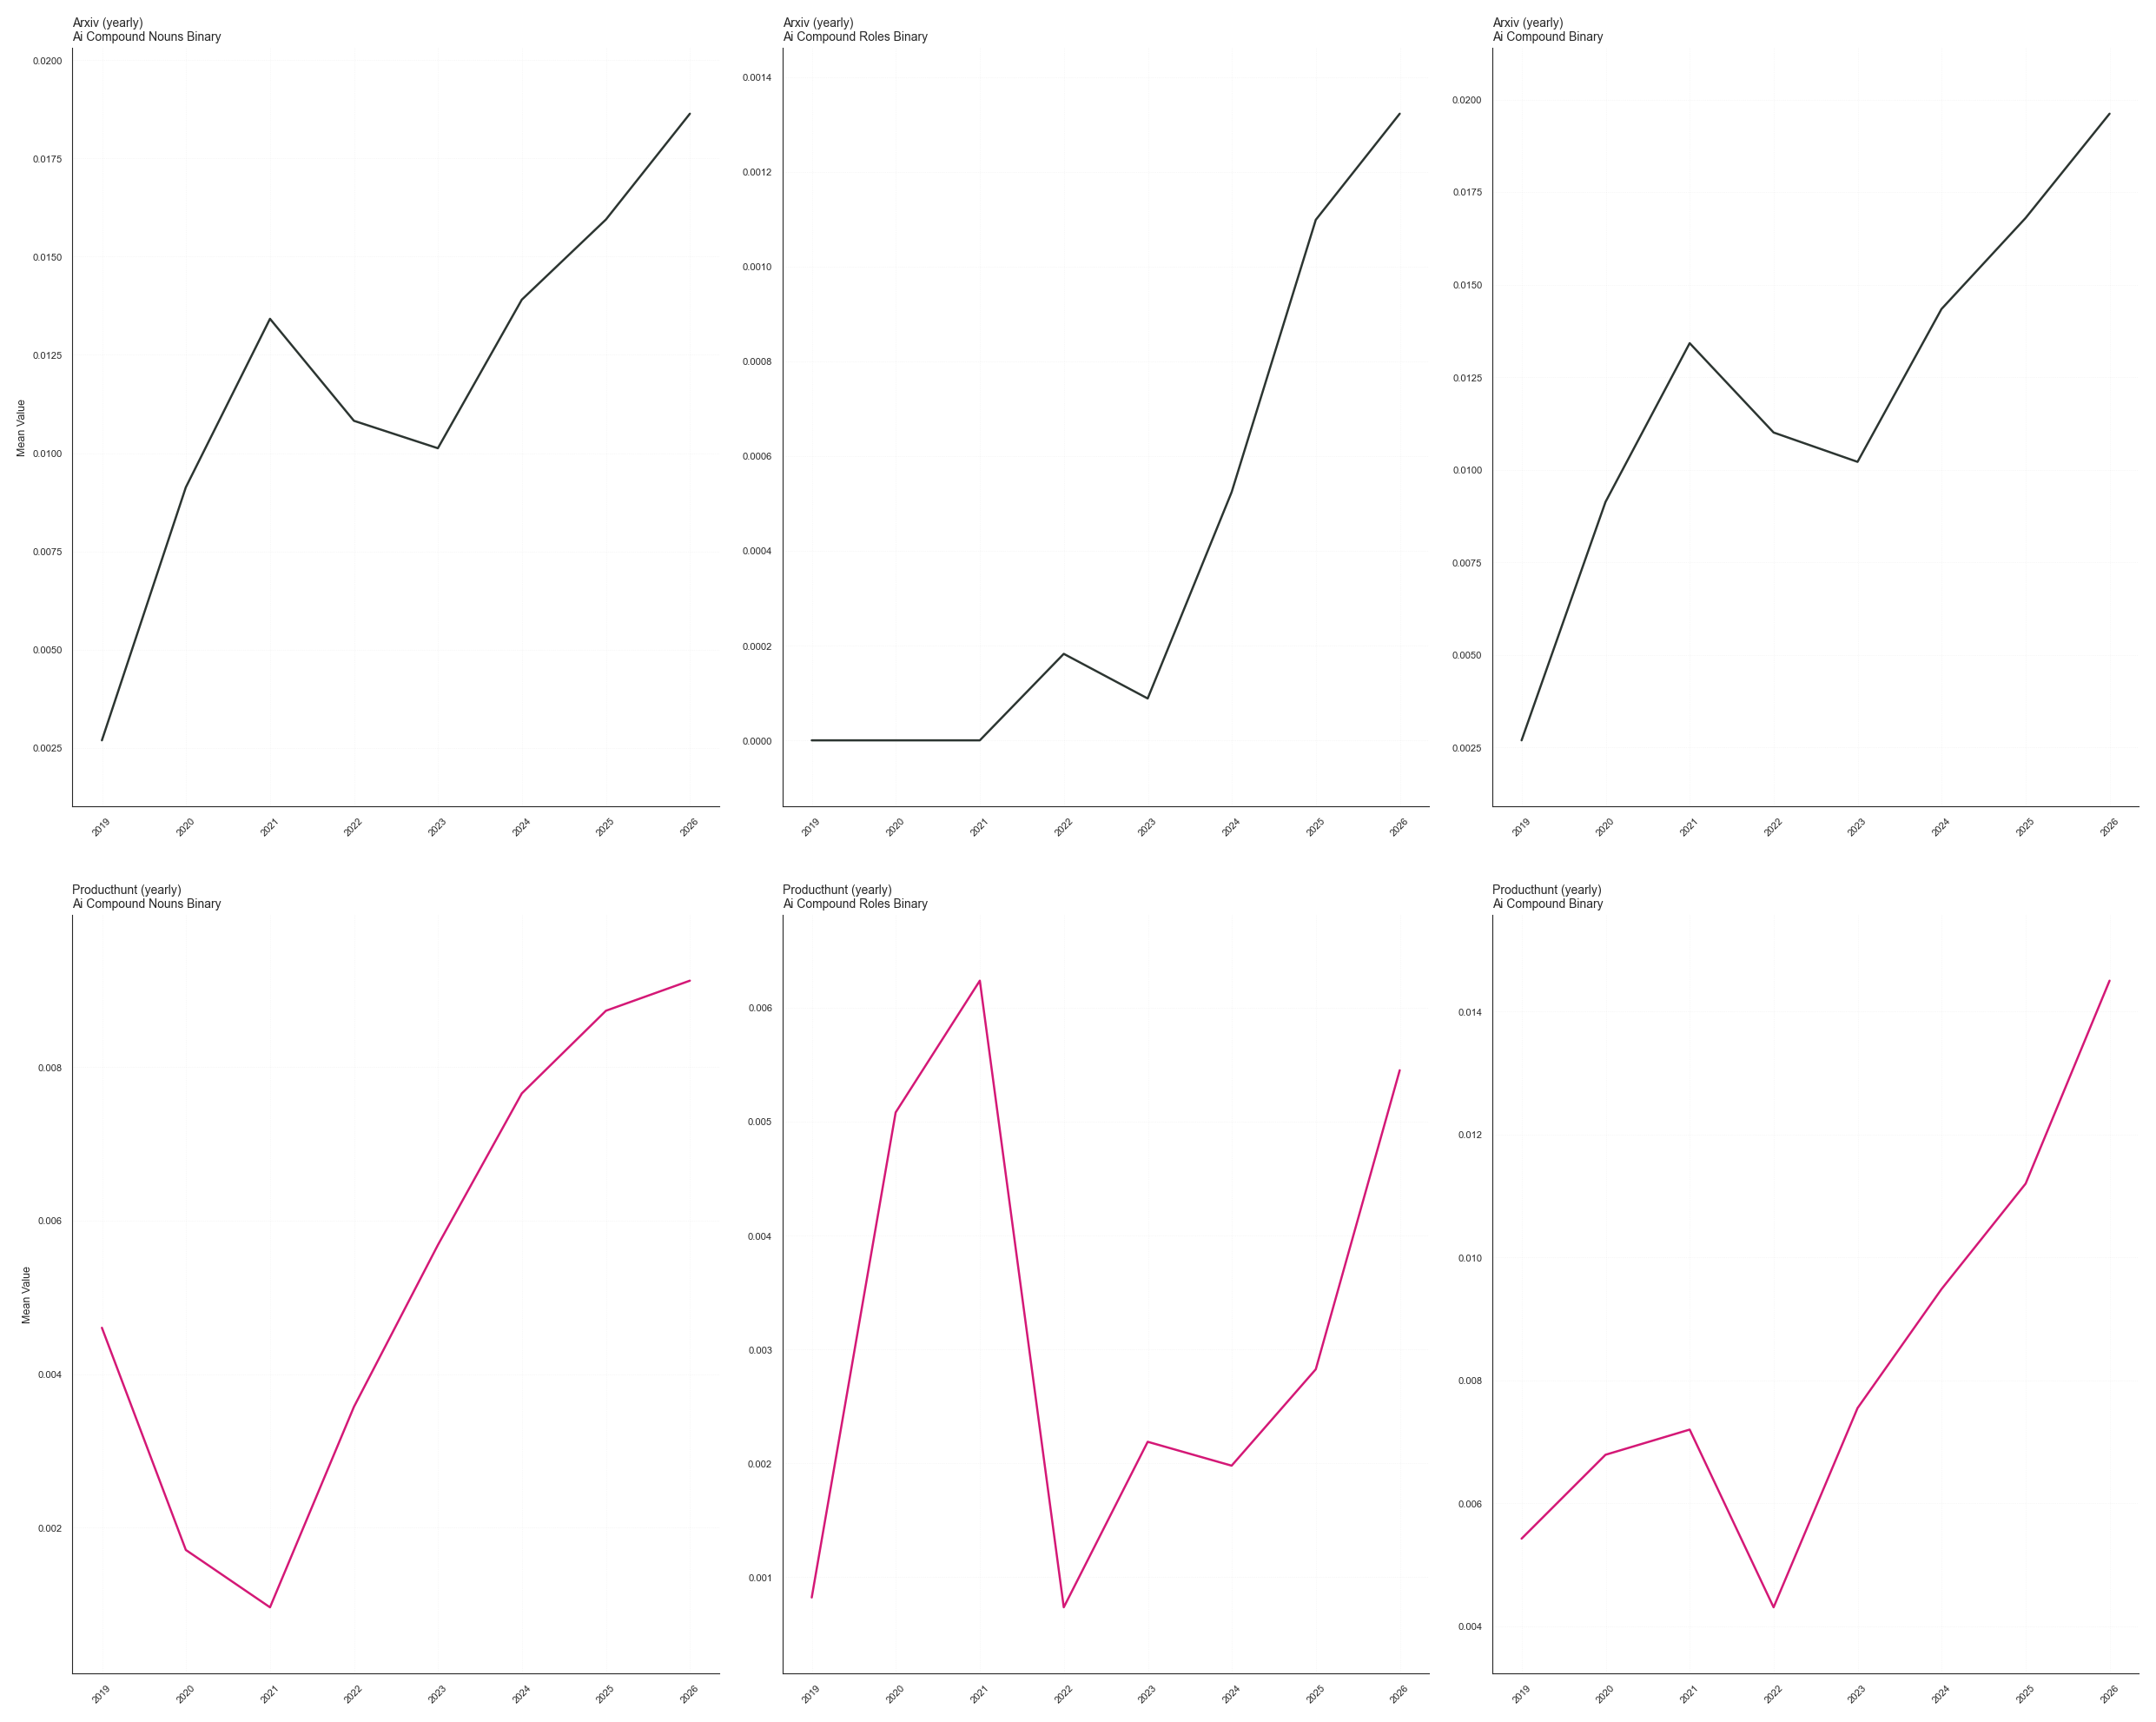

In [15]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os


def save_all_ts_grid(
    byday_dict,                      # Pass byday as parameter
    sources=('arxiv', 'producthunt'),
    dvs=('ai_compound_nouns_binary', 'ai_compound_roles_binary', 'ai_compound_binary'),
    periods=('yearly',),
    smoothing=False,                 # or e.g. 7 for a 7-day MA
    figsize=(25, 20),                # tweak as needed
    dpi=300,                         # high-resolution
    out_fn='all_time_series.png'
):
    """
    Saves a grid of time-series plots (source × period × DV) to `out_fn`.
    
    Args:
        byday_dict: Dictionary containing DataFrames for each source
        sources: Tuple of source names to plot
        dvs: Tuple of dependent variables (column names) to plot
        periods: Tuple of time periods for aggregation
        smoothing: False, True (7-day default), or integer for window size
        figsize: Figure size tuple
        dpi: Resolution for saved figure
        out_fn: Output filename
    """
    
    # Validate inputs
    for source in sources:
        if source not in byday_dict:
            raise ValueError(f"Source '{source}' not found in byday_dict")
    
    mypal = make_aesthetic()
    
    n_rows = len(sources) * len(periods)   
    n_cols = len(dvs)                      
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=False, sharey=False)
    
    # Handle single subplot case
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    color_map = {
        'arxiv': mypal[0],
        'producthunt': mypal[1], 
        'nyt': mypal[2],
    }
    
    # Add more colors if needed
    for i, source in enumerate(sources):
        if source not in color_map:
            color_map[source] = mypal[i % len(mypal)]

    axes_iter = axes.reshape(-1, n_cols)

    for r, (source, period) in enumerate(
        [(s, p) for s in sources for p in periods]   # keeps the grid order stable
    ):
        for c, dv in enumerate(dvs):
            ax = axes_iter[r, c]

            try:
                df = byday_dict[source].copy()
                
                # Check if column exists
                if dv not in df.columns:
                    ax.text(0.5, 0.5, f'Column {dv}\nnot found', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{source} ({period})\n{dv}', pad=6)
                    continue
                
                # Ensure dt is datetime
                if not pd.api.types.is_datetime64_any_dtype(df['dt']):
                    df['dt'] = pd.to_datetime(df['dt'])
                
                # Determine aggregation method based on column name
                if 'sum' in dv.lower() and 'mean' not in dv.lower():
                    agg_method = 'sum'
                elif 'binary' in dv.lower() and 'sum' not in dv.lower():
                    agg_method = 'mean'  # For proportions
                elif 'mean' in dv.lower():
                    agg_method = 'mean'
                elif 'count' in dv.lower():
                    agg_method = 'sum'
                else:
                    agg_method = 'mean'  # Default fallback

                # Aggregate to the requested period
                df_indexed = df.set_index('dt')
                
                if period == 'daily':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('D')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('D')[dv].mean().reset_index()
                elif period == 'weekly':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('W')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('W')[dv].mean().reset_index()
                elif period == 'monthly':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('M')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('M')[dv].mean().reset_index()
                elif period == 'yearly':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('Y')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('Y')[dv].mean().reset_index()
                else:
                    raise ValueError("period must be 'daily', 'weekly', 'monthly', or 'yearly'")

                # Remove any NaN values
                df_plot = df_plot.dropna()
                
                if len(df_plot) == 0:
                    ax.text(0.5, 0.5, 'No data\navailable', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{source} ({period})\n{dv}', pad=6)
                    continue

                # Optional smoothing
                plot_col = dv
                if smoothing and len(df_plot) > 2:
                    window = 7 if smoothing is True else int(smoothing)
                    window = min(window, len(df_plot))  # Don't exceed data length
                    df_plot[f'{dv}_smooth'] = df_plot[dv].rolling(window, center=True, min_periods=1).mean()
                    plot_col = f'{dv}_smooth'

                # Draw the line
                ax.plot(df_plot['dt'], df_plot[plot_col], 
                       linewidth=1.8, color=color_map.get(source, mypal[0]))
                
                # Format title and labels
                clean_dv = dv.replace('_', ' ').title()
                ax.set_title(f'{source.title()} ({period})\n{clean_dv}', pad=6, fontsize=10)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                ax.tick_params(axis='y', labelsize=8)
                ax.grid(alpha=0.3)

                # Add some padding to y-axis
                y_min, y_max = ax.get_ylim()
                y_range = y_max - y_min
                ax.set_ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)

                # Light y-label only on leftmost column
                if c == 0:
                    ax.set_ylabel(f'{agg_method.title()} Value', fontsize=9)
                    
            except Exception as e:
                # Handle errors gracefully
                ax.text(0.5, 0.5, f'Error:\n{str(e)[:50]}...', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=8)
                ax.set_title(f'{source} ({period})\n{dv}', pad=6)
                print(f"Warning: Error plotting {source}-{period}-{dv}: {e}")

    fig.tight_layout(h_pad=2.0, w_pad=1.0)
    
    # Save before showing to avoid issues
    fig.savefig(out_fn, dpi=dpi, bbox_inches='tight')
    print(f"✅  Saved grid to {out_fn}")
    
    plt.show()
    plt.close(fig)

save_all_ts_grid(byday)

In [5]:
dfs['arxiv'].columns

Index(['base-ai_word_counts', 'ai_word_counts', 'social_word_counts',
       'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts',
       'ai_compound_word_counts', 'advice_word_counts', 'base-ai_sum',
       'ai_sum', 'social_sum', 'ai_compound_roles_sum',
       'ai_compound_nouns_sum', 'ai_compound_sum', 'advice_sum',
       'base-ai_binary', 'ai_binary', 'social_binary',
       'ai_compound_roles_binary', 'ai_compound_nouns_binary',
       'ai_compound_binary', 'advice_binary', 'analysis_date', 'unique_idx',
       'text', 'wc', 'dt', 'total_count', 'social_word_counts_tfidf',
       'sum_social_word_counts_tfidf', 'base-ai_sum_mean',
       'base-ai_sum_mean_prop_wc', 'ai_sum_mean', 'ai_sum_mean_prop_wc',
       'social_sum_mean', 'social_sum_mean_prop_wc',
       'ai_compound_roles_sum_mean', 'ai_compound_roles_sum_mean_prop_wc',
       'ai_compound_nouns_sum_mean', 'ai_compound_nouns_sum_mean_prop_wc',
       'ai_compound_sum_mean', 'ai_compound_sum_mean_prop_wc',
  

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/1972596607.py:42: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=df_plot, x='dt', y=col, ci=95, join=True)
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_20676/1972596607.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


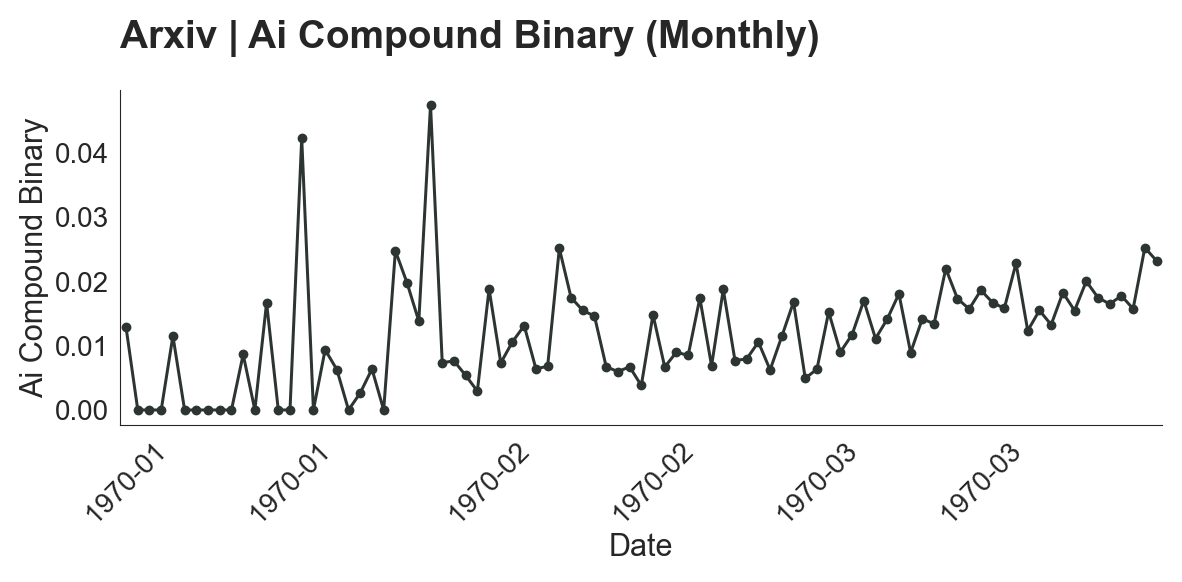

# Top Things


In [7]:
def view_top_bottom(df, col, n):
    """
    View top and bottom values of a specific column in a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze
        col (str): The column name to view
    
    Returns:
        pd.DataFrame: DataFrame with top and bottom values of the specified column
    """
    top = df.nlargest(n, col)
    bottom = df.nsmallest(n, col)
    
    print("TOP")
    for index, row in top.iterrows():
        text = row['text']
        print(f"{row[col]:.2f} - {text[:40*1000]}...") 
        print("---"*10)
        
    print("BOTTOM")
    for index, row in bottom.iterrows():
        text = row['text']
        print(f"{row[col]:.2f} - {text[:40*1000]}...") 
        print("---"*10)
    
    return pd.concat([top, bottom]).reset_index(drop=True)


view_top_bottom(dfs['arxiv'], 'sum_social_word_counts_tfidf_mean_prop_wc', 30)

TOP
22.73 - ai code generators for security: friend or foe? recent advances of artificial intelligence (ai) code generators are opening new opportunities in software security research, including misuse by malicious actors. we review use cases for ai code generators for security and introduce an evaluation benchmark....
------------------------------
11.36 - sabi\'a-3 technical report this report presents sabi\'a-3, our new flagship language model, and sabiazinho-3, a more cost-effective sibling. the models were trained on a large brazilian-centric corpus. evaluations across diverse professional and academic benchmarks show a strong performance on portuguese and brazil-related tasks. sabi\'a-3 shows large improvements in comparison to our previous best of model, sabia-2 medium, especially in reasoning-intensive tasks. notably, sabi\'a-3's average performance matches frontier llms, while it is offered at a three to four times lower cost per token, reinforcing the benefits of domain speci

,base-ai_word_counts,ai_word_counts,social_word_counts,ai_compound_roles_word_counts,ai_compound_nouns_word_counts,ai_compound_word_counts,advice_word_counts,base-ai_sum,ai_sum,social_sum,...,advice_sum_mean_prop_wc,sum_social_word_counts_tfidf_mean,sum_social_word_counts_tfidf_mean_prop_wc,base-ai_binary_sum,ai_binary_sum,social_binary_sum,ai_compound_roles_binary_sum,ai_compound_nouns_binary_sum,ai_compound_binary_sum,advice_binary_sum
0,"{'ai': 3, 'artificial intelligence': 1}","{'ai': 3, 'artificial intelligence': 1}",{'friend': 1},{},{},{},{},4,4,1,...,0.0,1000,22.727273,1,1,1,0,0,0,0
1,{},"{'language model': 1, 'llms': 1}",{'sibling': 1},{},{},{},{},0,2,1,...,0.0,1000,11.363636,0,1,1,0,0,0,0
2,{},{'language models': 1},{'therapist': 2},{},{},{},{},0,1,2,...,0.0,1000,10.638298,0,1,1,0,0,0,0
3,{},{'transformers': 1},{'parent': 1},{},{},{},{},0,1,1,...,0.0,1000,10.204082,0,1,1,0,0,0,0
4,{},{'chatbots': 3},{'advisor': 1},{},{},{},{},0,3,1,...,0.0,1000,10.101010,0,1,1,0,0,0,0
5,{},{'language models': 3},{'employee': 2},{},{},{},{},0,3,2,...,0.0,1000,10.000000,0,1,1,0,0,0,0
6,{},{'language models': 1},{'parent': 1},{},{},{},{},0,1,1,...,0.0,1000,9.345794,0,1,1,0,0,0,0
7,{'ai': 4},{'ai': 4},{'advisor': 1},{},{},{},{},4,4,1,...,0.0,1000,8.620690,1,1,1,0,0,0,0
8,{'ai': 1},"{'ai': 1, 'llms': 1}",{'friend': 1},{},{},{},{},1,2,1,...,0.0,1000,7.936508,1,1,1,0,0,0,0
9,{'artificial intelligence': 1},{'artificial intelligence': 1},{'encouragement': 1},{},{},{},{},1,1,1,...,0.0,1000,7.812500,1,1,1,0,0,0,0


In [ ]:
bad_words = ['communication', "dialogue"]